In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import sklearn
import matplotlib.pyplot as plt
import optuna
from tqdm import tqdm

import mscproject.models as mod
import mscproject.experiment as exp

while not Path("data") in Path(".").iterdir():
    os.chdir("..")

In [2]:
PREDICTION_DIR = Path("data/predictions")
SELECT_MODELS = ["KGNN", "GraphSAGE", "CatBoost"]
OPTUNA_DB = Path("data/optuna-06.db")

In [3]:
# Matplotlib Settings
plt.style.use("seaborn-whitegrid")
plt.style.use("seaborn-paper")

FONT_SIZE = 12

# Set plot font size
plt.rcParams.update({"font.size": 10})

# Set axis label font size
plt.rcParams.update({"axes.labelsize": 10})

# Set legend font size
plt.rcParams.update({"legend.fontsize": 10})

# Set tick label font size
plt.rcParams.update({"xtick.labelsize": 9})

# Set tick label font size
plt.rcParams.update({"ytick.labelsize": 9})

# Set figure title font size
plt.rcParams.update({"axes.titlesize": FONT_SIZE})

In [4]:
prediction_dict = {
    preds_csv.stem: pd.read_csv(preds_csv, usecols=["pred_proba", "actual"])
    for preds_csv in PREDICTION_DIR.glob("*.csv")
    if preds_csv.stem in SELECT_MODELS
}
# prediction_dict["KGNN"] = prediction_dict.pop("KGNN")
POSITIVE_PROPORTION = next(iter(prediction_dict.values()))["actual"].mean()

In [5]:
print(POSITIVE_PROPORTION)

0.07334899504045941


In [6]:
def _axis_grid(ax, xlim, ylim, major=0.1, minor=0.05):
    ax.grid(which="major", axis="both", linestyle="solid")
    ax.grid(which="minor", axis="both", linestyle="dotted")
    ax.xaxis.set_major_locator(plt.MultipleLocator(major))
    ax.yaxis.set_major_locator(plt.MultipleLocator(major))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(minor))
    ax.yaxis.set_minor_locator(plt.MultipleLocator(minor))
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    if xlim == ylim == (0, 1):
        ax.set_aspect("equal")

In [7]:
def plot_roc_curve(ax, preds, label, xlim=(0, 1), ylim=(0, 1), **plot_kwargs):
    ax.set_title("ROC Curve")
    sklearn.metrics.RocCurveDisplay.from_predictions(
        preds["actual"],
        preds["pred_proba"],
        name=label,
        ax=ax,
        drop_intermediate=False,
        **plot_kwargs,
    )
    _axis_grid(ax, xlim, ylim)

In [8]:
def plot_pr_curve(ax, preds, label, xlim=(0, 1), ylim=(0, 1), **plot_kwargs):
    ax.set_title("Precision-Recall Curve")
    sklearn.metrics.PrecisionRecallDisplay.from_predictions(
        y_true=preds["actual"],
        y_pred=preds["pred_proba"],
        name=label,
        ax=ax,
        drawstyle="default",
        **plot_kwargs,
    )
    _axis_grid(ax, xlim, ylim)

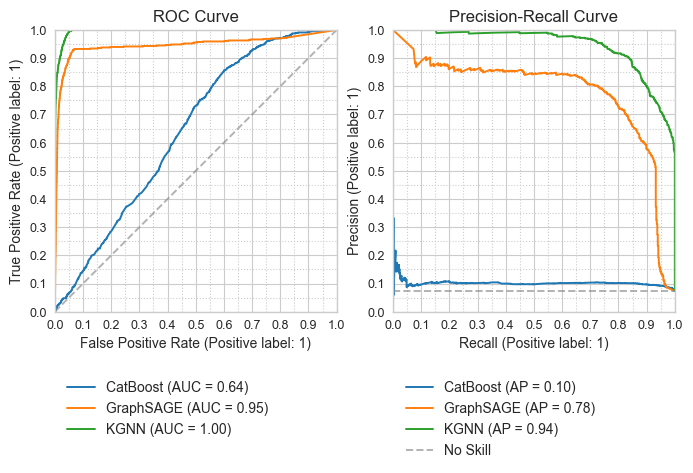

In [9]:
plot_kwargs = {"ls": "-", "alpha": 1}


def plot_roc_pr_curves(preds_dict, xlim=(0, 1), ylim=(0, 1), **updated_plot_kwargs):

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))

    positive_proportion = next(iter(preds_dict.values()))["actual"].mean()

    for model_name in sorted(preds_dict.keys()):
        preds = preds_dict[model_name]
        plot_roc_curve(axes[0], preds, model_name, xlim, ylim, **updated_plot_kwargs)
        plot_pr_curve(axes[1], preds, model_name, xlim, ylim, **updated_plot_kwargs)
    axes[0].plot([0, 1], [0, 1], linestyle="--", color="grey", alpha=0.6)
    axes[1].plot(
        [0, 1],
        [positive_proportion, positive_proportion],
        linestyle="--",
        color="grey",
        alpha=0.6,
        label="No Skill",
    )

    axes[0].legend(loc="upper left", bbox_to_anchor=(0, -0.2))
    axes[1].legend(loc="upper left", bbox_to_anchor=(0, -0.2))

    return fig


fig = plot_roc_pr_curves(prediction_dict, **plot_kwargs)
fig.savefig("figures/roc-pr-curve.png", dpi=300, bbox_inches="tight")

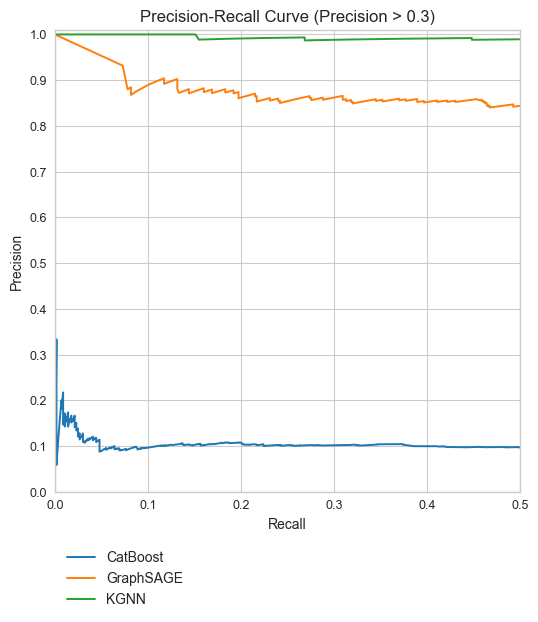

In [10]:
fig, ax = plt.subplots(figsize=(6, 6))

preds_dict = prediction_dict

for model_name in sorted(preds_dict.keys()):
    preds = preds_dict[model_name]
    pr_curve = sklearn.metrics.precision_recall_curve(
        preds["actual"], preds["pred_proba"]
    )
    ax.plot(pr_curve[1], pr_curve[0], label=model_name, **plot_kwargs)

ax.legend(loc="upper left", bbox_to_anchor=(0, -0.1))
ax.set_title("Precision-Recall Curve (Precision > 0.3)")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_xlim(0.0, 0.5)
ax.set_ylim(0.0, 1.01)
ax.set_aspect("auto")

major = 0.1
minor = 0.05

ax.xaxis.set_major_locator(plt.MultipleLocator(major))
ax.xaxis.set_minor_locator(plt.MultipleLocator(minor))

ax.yaxis.set_major_locator(plt.MultipleLocator(major))
ax.yaxis.set_minor_locator(plt.MultipleLocator(minor))

fig.savefig(
    "figures/precision-recall-curve-high-precision.png", dpi=300, bbox_inches="tight"
)

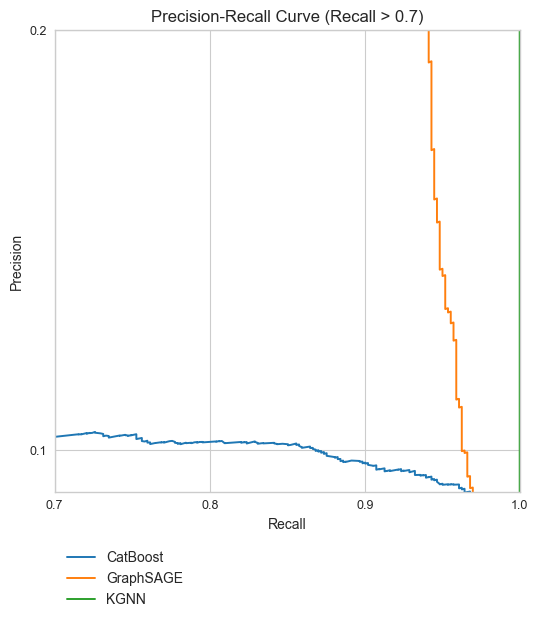

In [11]:
fig, ax = plt.subplots(figsize=(6, 6))

preds_dict = prediction_dict

for model_name in sorted(preds_dict.keys()):
    preds = preds_dict[model_name]
    pr_curve = sklearn.metrics.precision_recall_curve(
        preds["actual"], preds["pred_proba"]
    )
    ax.plot(pr_curve[1], pr_curve[0], label=model_name, **plot_kwargs)

ax.legend(loc="upper left", bbox_to_anchor=(0, -0.1))
ax.set_title("Precision-Recall Curve (Recall > 0.7)")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_xlim(0.7, 1.0)
ax.set_ylim(0.09, 0.2)
ax.set_aspect("auto")

major = 0.1
minor = 0.05

ax.xaxis.set_major_locator(plt.MultipleLocator(major))
ax.xaxis.set_minor_locator(plt.MultipleLocator(minor))

ax.yaxis.set_major_locator(plt.MultipleLocator(major))
ax.yaxis.set_minor_locator(plt.MultipleLocator(minor))

# fig.tight_layout()

fig.savefig(
    "figures/precision-recall-curve-high-recall.png", dpi=300, bbox_inches="tight"
)

In [12]:
def plot_precision_at_threshold(
    ax, preds, label, xlim=(0, 1), ylim=(0, 1), **plot_kwargs
):
    ax.set_title("Precision at Threshold")
    precision, recall, thresholds = sklearn.metrics.precision_recall_curve(
        preds["actual"], preds["pred_proba"]
    )
    ax.plot(thresholds, precision[:-1], label=label, **plot_kwargs)
    ax.set_xlabel("Threshold")
    ax.set_ylabel("Precision")
    _axis_grid(ax, xlim, ylim)

In [13]:
def plot_recall_at_threshold(ax, preds, label, xlim=(0, 1), ylim=(0, 1), **plot_kwargs):
    ax.set_title("Recall at Threshold")
    precision, recall, thresholds = sklearn.metrics.precision_recall_curve(
        preds["actual"], preds["pred_proba"]
    )
    ax.plot(thresholds, recall[:-1], label=label, **plot_kwargs)
    ax.set_xlabel("Threshold")
    ax.set_ylabel("Recall")
    _axis_grid(ax, xlim, ylim)

In [14]:
def plot_f1_at_threshold(ax, preds, label, xlim=(0, 1), ylim=(0, 1), **plot_kwargs):
    ax.set_title("F1 at Threshold")
    precision, recall, thresholds = sklearn.metrics.precision_recall_curve(
        preds["actual"], preds["pred_proba"]
    )
    f1 = 2 * (precision * recall) / (precision + recall)
    ax.plot(thresholds, f1[:-1], label=label, **plot_kwargs)
    ax.set_xlabel("Threshold")
    ax.set_ylabel("F1")
    _axis_grid(ax, xlim, ylim)

In [15]:
def plot_mcc_at_threshold(ax, preds, label, xlim=(0, 1), ylim=(0, 1), **plot_kwargs):
    ax.set_title("Matthews Correlation Coefficient at Threshold")
    thresholds = np.linspace(0, 1, 100)
    tuples = [
        (
            threshold,
            sklearn.metrics.matthews_corrcoef(
                preds["actual"], preds["pred_proba"] > threshold
            ),
        )
        for threshold in thresholds
    ]
    thresholds, mcc = zip(*tuples)
    ax.plot(thresholds, mcc, label=label, **plot_kwargs)
    ax.set_xlabel("Threshold")
    ax.set_ylabel("MCC")
    _axis_grid(ax, xlim, ylim)

In [16]:
def plot_tpr_at_threshold(ax, preds, label, xlim=(0, 1), ylim=(0, 1), **plot_kwargs):
    ax.set_title("True Positive Rate at Threshold")
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(
        preds["actual"], preds["pred_proba"]
    )
    ax.plot(thresholds, tpr, label=label, **plot_kwargs)
    ax.set_xlabel("Threshold")
    ax.set_ylabel("True Positive Rate")
    _axis_grid(ax, xlim, ylim)

In [17]:
def plot_fpr_at_threshold(ax, preds, label, xlim=(0, 1), ylim=(0, 1), **plot_kwargs):
    ax.set_title("False Positive Rate at Threshold")
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(
        preds["actual"], preds["pred_proba"]
    )
    ax.plot(thresholds, fpr, label=label, **plot_kwargs)
    ax.set_xlabel("Threshold")
    ax.set_ylabel("False Positive Rate")
    _axis_grid(ax, xlim, ylim)

In [18]:
def plot_fnr_at_threshold(ax, preds, label, xlim=(0, 1), ylim=(0, 1), **plot_kwargs):
    ax.set_title("False Negative Rate at Threshold")
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(
        preds["actual"], preds["pred_proba"]
    )
    fnr = 1 - tpr
    ax.plot(thresholds, fnr, label=label, **plot_kwargs)
    ax.set_xlabel("Threshold")
    ax.set_ylabel("False Negative Rate")
    _axis_grid(ax, xlim, ylim)

### Reference: https://fraud-detection-handbook.github.io/fraud-detection-handbook/Chapter_4_PerformanceMetrics/ThresholdFree.html

In [19]:
def plot_precision_recall_at_threshold(
    preds_dict, xlim=(0, 1), ylim=(0, 1), **updated_plot_kwargs
):

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 12))

    axes = np.ravel(axes)

    for model_name in sorted(preds_dict.keys()):
        preds = preds_dict[model_name]
        plot_precision_at_threshold(
            axes[0], preds, model_name, xlim, ylim, **updated_plot_kwargs
        )
        plot_recall_at_threshold(
            axes[1], preds, model_name, xlim, ylim, **updated_plot_kwargs
        )
        plot_tpr_at_threshold(
            axes[2], preds, model_name, xlim, ylim, **updated_plot_kwargs
        )
        plot_fpr_at_threshold(
            axes[3], preds, model_name, xlim, ylim, **updated_plot_kwargs
        )
        # plot_fnr_at_threshold(axes[3], preds, model_name, xlim, ylim, **updated_plot_kwargs)
        # plot_f1_at_threshold(axes[4], preds, model_name, xlim, ylim, **updated_plot_kwargs)
        # plot_mcc_at_threshold(axes[5], preds, model_name, xlim, ylim, **updated_plot_kwargs)

    # axes[-2].legend(loc="upper left", bbox_to_anchor=(0, -0.1))
    axes[-2].legend(loc="upper left", bbox_to_anchor=(0, -0.1))

    fig.tight_layout()

    return fig

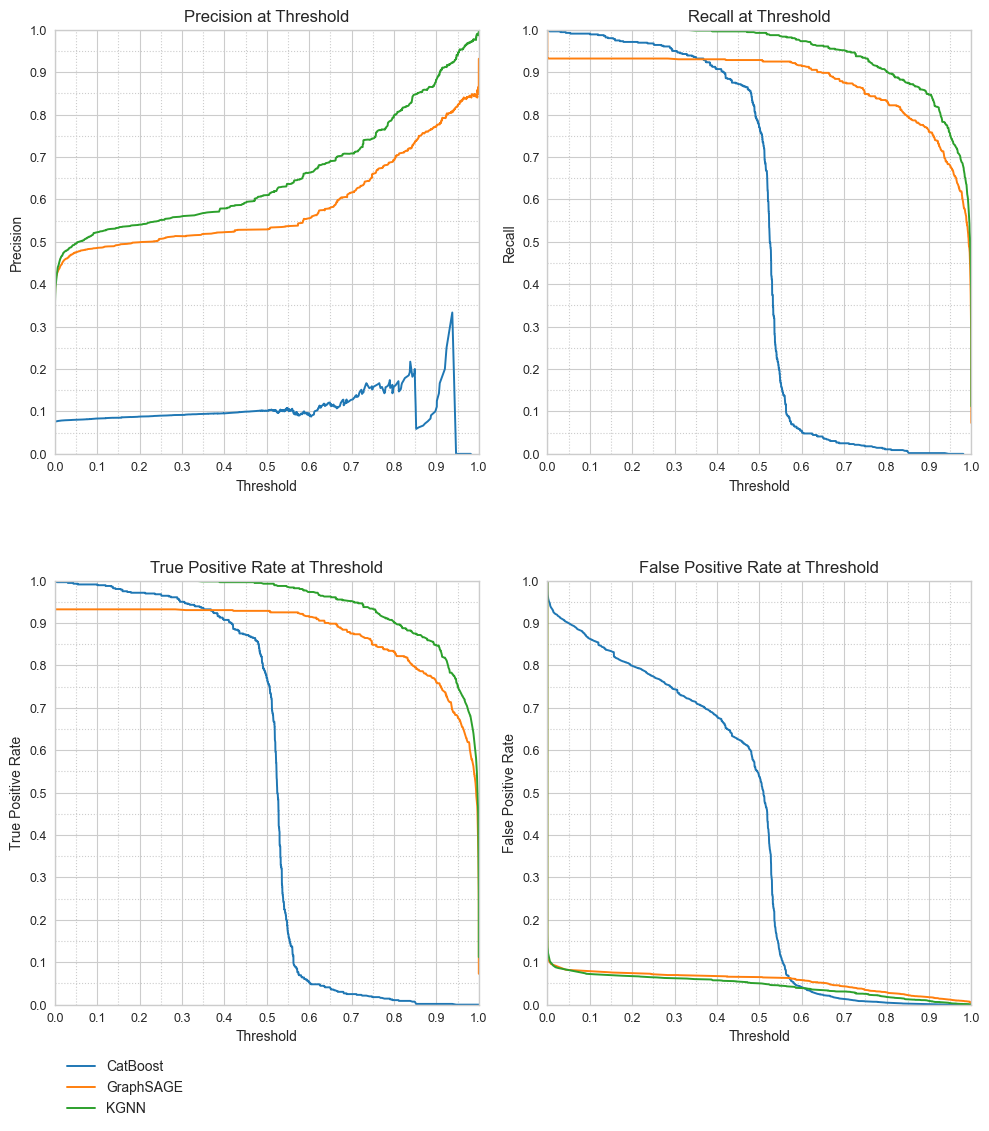

In [20]:
_ = plot_precision_recall_at_threshold(
    prediction_dict, xlim=(0, 1), ylim=(0, 1), **plot_kwargs
)

### Top K Metrics

### Reference: https://fraud-detection-handbook.github.io/fraud-detection-handbook/Chapter_4_PerformanceMetrics/TopKBased.htmlm

In [21]:
def top_k_metrics(y_true, y_pred, k=10):
    """Compute top k metrics for a given k"""
    top_k_pred = y_pred.sort_values()[-k:]
    top_k_actual = y_true.loc[top_k_pred.index]
    return top_k_actual.sum() / top_k_actual.count()

In [22]:
y_test = prediction_dict["KGNN"]["actual"]
y_pred = prediction_dict["KGNN"]["pred_proba"]
top_k_metrics(y_test, y_pred, k=1000)

0.562

In [23]:
def plot_topk_precision(preds_dict, k=(100, 10000), **updated_plot_kwargs):
    """Plot the top k precision for a range of k"""
    fig, ax = plt.subplots(figsize=(8, 6))

    ax.set_title(f"Top K Precision")
    ax.set_xlabel("# Nodes")
    ax.set_ylabel("Precision")

    for model_name in sorted(preds_dict.keys()):
        preds = preds_dict[model_name]
        y_test = preds["actual"]
        y_pred = preds["pred_proba"]
        top_k_score = [top_k_metrics(y_test, y_pred, k) for k in range(*k)]
        ax.plot(range(*k), top_k_score, label=model_name, **updated_plot_kwargs)

    ax.grid(which="major", axis="both", linestyle="solid")
    ax.grid(which="minor", axis="both", linestyle="dotted")

    ax.xaxis.set_major_locator(plt.MultipleLocator(500))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(100))

    ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
    ax.yaxis.set_minor_locator(plt.MultipleLocator(0.05))

    ax.set_xlim(k[0], k[1])
    ax.set_ylim(0, 1)

    ax.legend(loc="upper left", bbox_to_anchor=(0, -0.1))

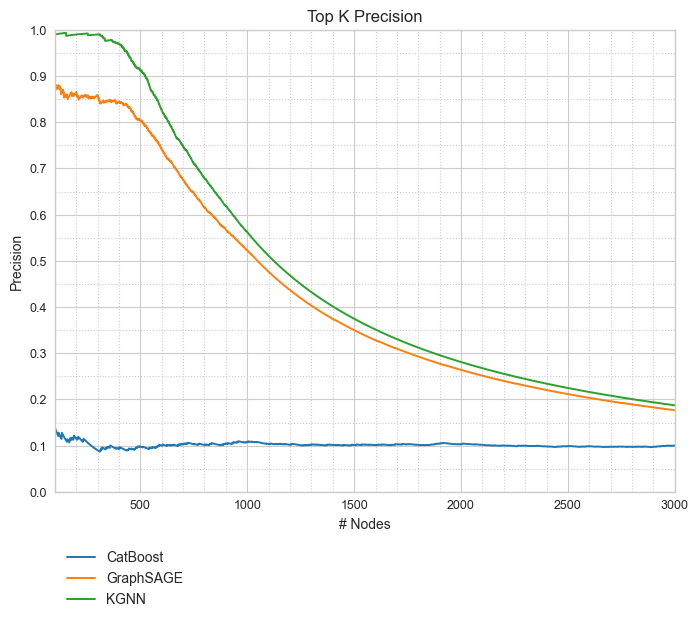

In [24]:
plot_topk_precision(prediction_dict, k=(100, 3000), **plot_kwargs)

In [25]:
import math


def plot_confusion_matrix(ax, preds, label, **plot_kwargs):
    sklearn.metrics.ConfusionMatrixDisplay.from_predictions(
        y_true=preds["actual"],
        y_pred=preds["pred_proba"] >= 0.5,
        ax=ax,
        values_format=".3f",
        normalize="all",
        colorbar=False,
        **plot_kwargs,
    )
    ax.set_title(label)
    ax.grid(False)


def plot_confusion_matrices(preds_dict):
    fig, axes = plt.subplots(
        nrows=math.ceil(len(preds_dict) / 2), ncols=2, figsize=(4, 6)
    )
    axes = np.ravel(axes)
    for i, model_name in enumerate(sorted(preds_dict.keys())):
        preds = preds_dict[model_name]

        plot_confusion_matrix(axes[i], preds, model_name)

    fig.tight_layout()
    fig.savefig("figures/confusion-matrices.png", dpi=300)

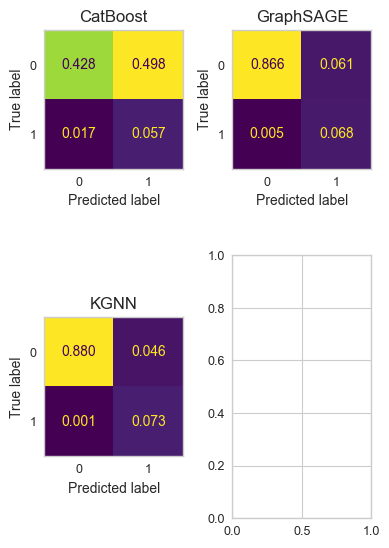

In [26]:
plot_confusion_matrices(prediction_dict)

In [27]:
# Get classification report as a dataframe
def get_classification_report_df(preds, threshold=0.5):
    return (
        pd.DataFrame(
            sklearn.metrics.classification_report(
                preds["actual"], preds["pred_proba"] >= threshold, output_dict=True
            )
        )
        .drop("support")
        .drop("accuracy", axis=1)
    )

In [28]:
# Highlight highest value in each column
def highlight_max(s):
    is_max = s == s.max()
    return ["font-weight: bold" if v else "" for v in is_max]

In [29]:
def get_classification_report_combined_df(preds_dict, threshold=0.5):
    df = (
        pd.concat(
            [
                get_classification_report_df(preds, threshold)
                for preds in preds_dict.values()
            ],
            keys=preds_dict.keys(),
            axis=0,
        )
        .round(3)
        .T.stack()
    )

    # Label indexes
    df.index.names = ["Class", "Metric"]

    df.to_csv(f"reports/classification-report-threshold-{threshold}.csv")
    df.style.apply(highlight_max, axis=1).format("{:.3f}").to_html(
        f"reports/classification-report-threshold-{threshold}.html"
    )

    return df

In [30]:
df = get_classification_report_combined_df(prediction_dict, threshold=0.5)
df.style.apply(highlight_max, axis=1).format("{:.3f}")

In [31]:
df = get_classification_report_combined_df(prediction_dict, threshold=0.1)
df.style.apply(highlight_max, axis=1).format("{:.3f}")

In [32]:
df = get_classification_report_combined_df(prediction_dict, threshold=0.05)
df.style.apply(highlight_max, axis=1).format("{:.3f}")

In [33]:
df = get_classification_report_combined_df(prediction_dict, threshold=0.01)
df.style.apply(highlight_max, axis=1).format("{:.3f}")

## Threshold Free Performance Metrics

In [34]:
# Get model performance metrics as a dataframe
# Use AUC for ROC and PR curves, and F1 score for confusion matrix
# https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix
def get_model_performance_metrics(preds, threshold=0.5):
    return {
        "AUC-ROC": sklearn.metrics.roc_auc_score(preds["actual"], preds["pred_proba"]),
        "AUC-PR": sklearn.metrics.average_precision_score(
            preds["actual"], preds["pred_proba"]
        ),
        # "F1 Score": sklearn.metrics.f1_score(
        #     preds["actual"], preds["pred_proba"] >= threshold
        # ),
    }


def get_model_performance_metrics_df(preds_dict, threshold=0.5):
    df = pd.DataFrame(
        [
            get_model_performance_metrics(preds, threshold)
            for preds in preds_dict.values()
        ],
        index=preds_dict.keys(),
    ).round(3)

    df = df.sort_index().T

    df.to_csv("reports/model-performance-metrics.csv")
    df.style.apply(highlight_max, axis=0).format("{:.3f}").to_html(
        "reports/model-performance-metrics.html"
    )

    return df

In [35]:
df = get_model_performance_metrics_df(prediction_dict, threshold=0.5)
styled = df.style.apply(highlight_max, axis=1).format("{:.3f}")
styled.to_html("reports/model-performance-metrics.html")
styled

,CatBoost,GraphSAGE,KGNN
AUC-ROC,0.639,0.945,0.995
AUC-PR,0.103,0.775,0.945


In [36]:
def get_model_performance_metrics_np(y_true, y_pred_proba, threshold=0.5):
    return {
        "AUC-ROC": sklearn.metrics.roc_auc_score(y_true, y_pred_proba),
        "AUC-PR": sklearn.metrics.average_precision_score(y_true, y_pred_proba),
        "F1 Score": sklearn.metrics.f1_score(y_true, y_pred_proba >= threshold),
    }

In [37]:
def bootstrap_model_performance_metrics(preds_dict, threshold=0.5, n=1000):
    # This should be parallelised.

    metrics = {}

    for model_name, preds in preds_dict.items():
        y_true = preds["actual"].to_numpy()
        y_pred_proba = preds["pred_proba"].to_numpy()

        y_true_sample_array, pred_proba_sample_array = sklearn.utils.resample(
            y_true, y_pred_proba, replace=True, n_samples=n * len(y_true), random_state=42
        )

        y_true_sample_array = y_true_sample_array.reshape(n, len(y_true))
        pred_proba_sample_array = pred_proba_sample_array.reshape(n, len(y_true))
        
        metrics[model_name] = [
            get_model_performance_metrics_np(y_true_sample_array[i], pred_proba_sample_array[i], threshold)
            for i in range(len(y_true_sample_array))
        ]

    rows = [{"Model": k, **row} for k, v in metrics.items() for row in v]
    bootstrap_trials_df = pd.DataFrame(rows)

    return bootstrap_trials_df

In [38]:
def plot_bootstrap_interval_hists(bootstrap_trials_df):

    nrows = bootstrap_trials_df.shape[1] - 1

    fig, axes = plt.subplots(nrows=nrows, figsize=(12, nrows * 6))
    for i, col in enumerate(bootstrap_trials_df.columns.values[1:]):
        ax = axes[i]
        title = f"Bootstrapped {col} Values"
        ax.set_title(title)
        ax.set_xlabel(col)
        ax.set_ylabel("Frequency")
        bootstrap_trials_df.groupby("Model")[col].plot(
            kind="hist", bins=100, alpha=0.4, legend=False, ax=ax
        )
        # Plot vertical line at mean
        for i, model in enumerate(sorted(bootstrap_trials_df["Model"].unique())):
            ax.axvline(
                bootstrap_trials_df[bootstrap_trials_df["Model"] == model][col].mean(),
                color=f"C{i}",
                linestyle="dashed",
                linewidth=1.5,
            )
    ax.legend(
        sorted(bootstrap_trials_df["Model"].unique()),
        loc="upper left",
        bbox_to_anchor=(0, -0.1),
    )

In [39]:
def plot_bootstrap_interval_boxplots(bootstrap_trials_df):

    nrows = bootstrap_trials_df.shape[1] - 1

    fig, axes = plt.subplots(nrows=nrows, figsize=(12, nrows * 6))
    for i, col in enumerate(bootstrap_trials_df.columns.values[1:]):
        ax = axes[i]
        title = f"Bootstrapped {col} Values"
        bootstrap_trials_df.boxplot(column=col, by="Model", ax=ax)
        ax.set_title(title)
        ax.set_xlabel("Model")
        ax.set_ylabel(col)
    fig.suptitle("")

In [40]:
RERUN = False
bootstrap_trials_df_path = "data/evaluation/bootstrap-trials.csv"
if not Path(bootstrap_trials_df_path).exists() or RERUN:
    bootstrap_trials_df = bootstrap_model_performance_metrics(
        prediction_dict, threshold=0.5, n=10000
    )
    bootstrap_trials_df.to_csv(bootstrap_trials_df_path, index=False)
else:
    bootstrap_trials_df = pd.read_csv(bootstrap_trials_df_path)
bootstrap_trials_df = bootstrap_trials_df.drop(columns=["F1 Score"]).query(
    "Model in @SELECT_MODELS"
)

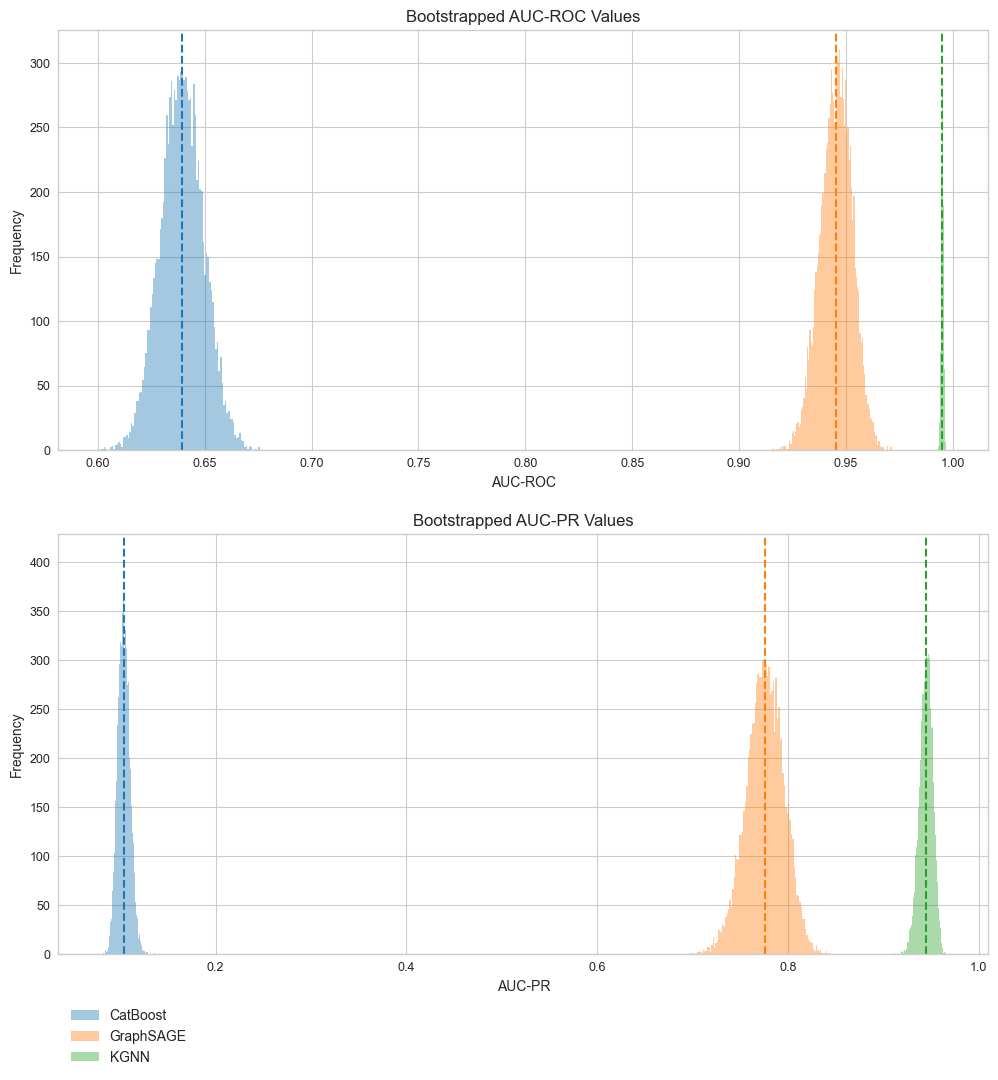

In [41]:
plot_bootstrap_interval_hists(bootstrap_trials_df)

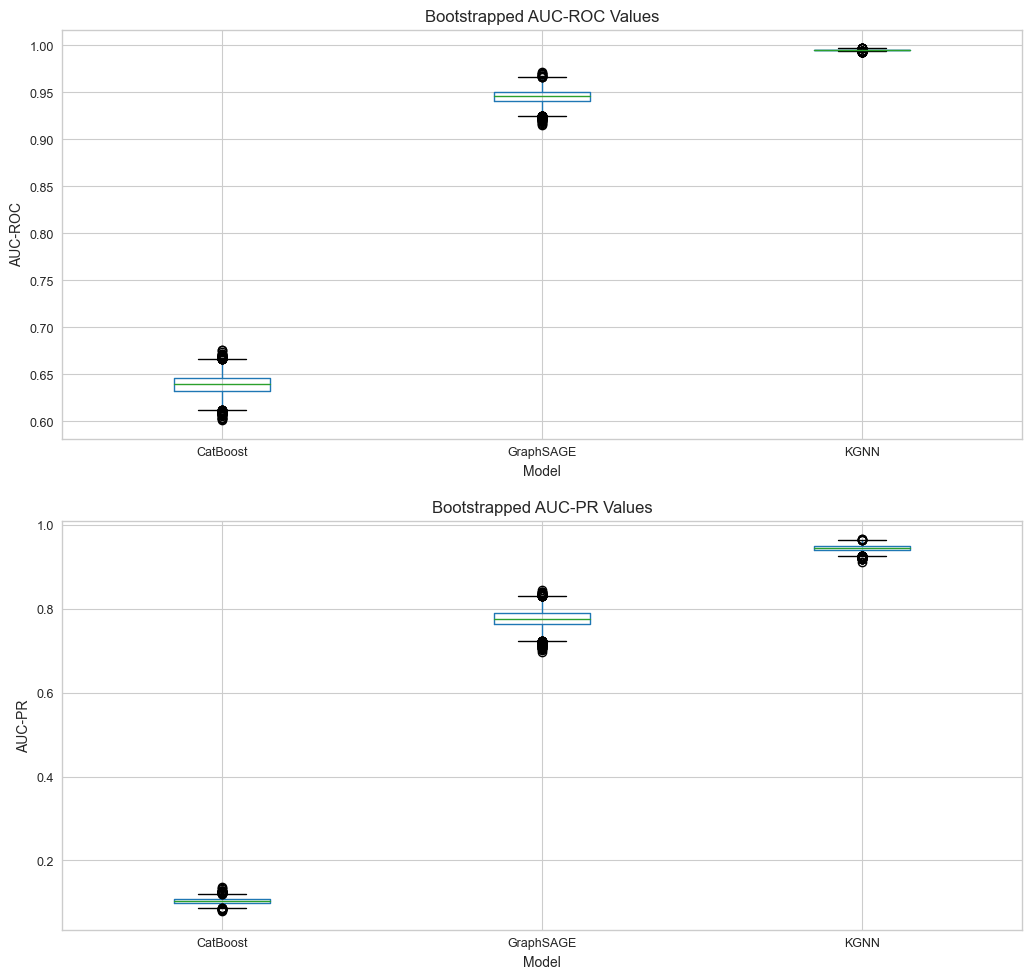

In [42]:
plot_bootstrap_interval_boxplots(bootstrap_trials_df)

In [43]:
def get_bootstrap_intervals_df(bootstrap_trials_df):
    bootstrap_intervals = (
        bootstrap_trials_df.groupby("Model").agg(["mean", "std"]).round(3)
    )

    bootstrap_intervals = bootstrap_intervals.sort_index(axis=1, ascending=False)

    # Add 95% confidence interval
    for metric in bootstrap_intervals.columns.levels[0]:
        bootstrap_intervals[metric, "95% CI"] = (
            "["
            + (
                bootstrap_intervals[metric, "mean"]
                - 2 * bootstrap_intervals[metric, "std"]
            )
            .round(3)
            .astype(str)
            .str.cat(
                (
                    bootstrap_intervals[metric, "mean"]
                    + 2 * bootstrap_intervals[metric, "std"]
                )
                .round(3)
                .astype(str),
                sep=", ",
            )
            + "]"
        )

    bootstrap_intervals = bootstrap_intervals.drop("std", axis=1, level=1)
    bootstrap_intervals = bootstrap_intervals.sort_index(axis=1, ascending=False)

    return bootstrap_intervals

In [44]:
def get_bootstrap_intervals_df(bootstrap_trials_df):
    bootstrap_intervals = (
        bootstrap_trials_df.groupby("Model").agg(["mean", "std"]).round(3)
    )

    bootstrap_intervals = bootstrap_intervals.sort_index(axis=1, ascending=False)

    # Add 95% confidence interval
    for metric in bootstrap_intervals.columns.levels[0]:
        bootstrap_intervals[metric, "Lower 95% CI"] = (
            bootstrap_intervals[metric, "mean"] - 2 * bootstrap_intervals[metric, "std"]
        ).round(3)
        bootstrap_intervals[metric, ".Upper 95% CI"] = (
            bootstrap_intervals[metric, "mean"] + 2 * bootstrap_intervals[metric, "std"]
        ).round(3)

    bootstrap_intervals = bootstrap_intervals.drop("std", axis=1, level=1)
    bootstrap_intervals = bootstrap_intervals.sort_index(
        level=0, axis=1, ascending=False
    )

    return bootstrap_intervals

In [45]:
bootstrap_intervals = get_bootstrap_intervals_df(bootstrap_trials_df)
bootstrap_intervals.sort_values(by=("AUC-ROC", "mean"), ascending=False)

AUC-ROC                            AUC-PR                           
             mean Lower 95% CI .Upper 95% CI   mean Lower 95% CI .Upper 95% CI
Model                                                                         
KGNN        0.995        0.993         0.997  0.945        0.931         0.959
GraphSAGE   0.945        0.931         0.959  0.776        0.736         0.816
CatBoost    0.639        0.619         0.659  0.104        0.092         0.116

In [46]:
def get_bootstrap_ci(bootstrap_trials_df, metric):
    bootstrap_ci = bootstrap_trials_df[["Model", metric]]
    bootstrap_ci = bootstrap_ci.groupby("Model").agg(["mean", "std"]).round(3)
    bootstrap_ci["Lower 95% CI"] = (
        (bootstrap_ci[metric]["mean"] - 2 * bootstrap_ci[metric]["std"])
        .round(3)
        .astype(str)
        .str.ljust(5, "0")
    )
    bootstrap_ci["Upper 95% CI"] = (
        (bootstrap_ci[metric]["mean"] + 2 * bootstrap_ci[metric]["std"])
        .round(3)
        .astype(str)
        .str.ljust(5, "0")
    )
    bootstrap_ci = bootstrap_ci.drop("std", axis=1, level=1)
    bootstrap_ci["95% CI"] = bootstrap_ci[
        ["Lower 95% CI", "Upper 95% CI"]
    ].values.tolist()
    bootstrap_ci["95% CI"] = bootstrap_ci["95% CI"].apply(
        lambda x: str(x).replace("'", "")
    )
    bootstrap_ci = bootstrap_ci.drop(["Lower 95% CI", "Upper 95% CI"], axis=1)

    bootstrap_ci.columns = bootstrap_ci.columns.droplevel(-1)

    return bootstrap_ci


bootstrap_ci = get_bootstrap_ci(bootstrap_trials_df, "AUC-ROC")
bootstrap_ci.style.apply(highlight_max, subset="AUC-ROC", axis=0)

,AUC-ROC,95% CI
Model,,
CatBoost,0.639000,"[0.619, 0.659]"
GraphSAGE,0.945000,"[0.931, 0.959]"
KGNN,0.995000,"[0.993, 0.997]"


In [47]:
print(bootstrap_ci.to_markdown())

| Model     |   AUC-ROC | 95% CI         |
|:----------|----------:|:---------------|
| CatBoost  |     0.639 | [0.619, 0.659] |
| GraphSAGE |     0.945 | [0.931, 0.959] |
| KGNN      |     0.995 | [0.993, 0.997] |


In [48]:
def get_all_bootstrap_ci(bootstrap_trials_df):
    bootstrap_ci = pd.DataFrame()
    for metric in bootstrap_trials_df.columns.values[1:]:
        bootstrap_ci = pd.concat(
            [bootstrap_ci, get_bootstrap_ci(bootstrap_trials_df, metric)], axis=1
        )
    return bootstrap_ci

In [49]:
bootstrap_ci = get_all_bootstrap_ci(bootstrap_trials_df)
# Hack to make the column names unique so styling works
bootstrap_ci.to_csv("reports/model-performance-bootstrap-ci.csv")
bootstrap_ci.columns.values[1] = bootstrap_ci.columns.values[1] + " "
bootstrap_ci.style.apply(highlight_max, subset=["AUC-ROC", "AUC-PR"], axis=0).to_html(
    "reports/model-performance-bootstrap-ci.html"
)

In [50]:
bootstrap_ci.style.apply(highlight_max, subset=["AUC-ROC", "AUC-PR"], axis=0)

,AUC-ROC,95% CI,AUC-PR,95% CI
Model,,,,
CatBoost,0.639000,"[0.619, 0.659]",0.104000,"[0.092, 0.116]"
GraphSAGE,0.945000,"[0.931, 0.959]",0.776000,"[0.736, 0.816]"
KGNN,0.995000,"[0.993, 0.997]",0.945000,"[0.931, 0.959]"


In [51]:
print(bootstrap_ci.to_markdown())

| Model     |   AUC-ROC | 95% CI         |   AUC-PR | 95% CI         |
|:----------|----------:|:---------------|---------:|:---------------|
| CatBoost  |     0.639 | [0.619, 0.659] |    0.104 | [0.092, 0.116] |
| GraphSAGE |     0.945 | [0.931, 0.959] |    0.776 | [0.736, 0.816] |
| KGNN      |     0.995 | [0.993, 0.997] |    0.945 | [0.931, 0.959] |


## Training History

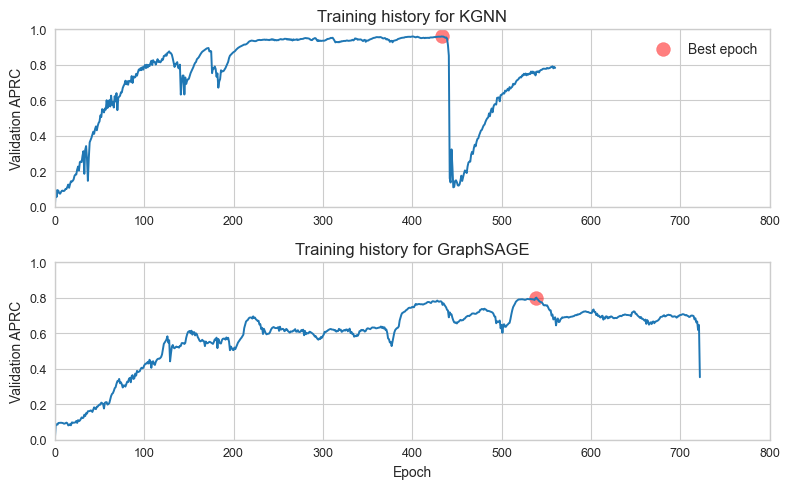

In [56]:
MODEL_DIR = Path("data/models/pyg/weights-unregularised/")

fig, axes = plt.subplots(nrows=2, figsize=(8, 5))

gnn_models = [
    x for x in SELECT_MODELS if x not in ["CatBoost", "RandomForest", "XGBoost"]
]

for i, model_name in enumerate(gnn_models):

    ax = axes[i]

    training_history = pd.read_csv(
        MODEL_DIR / f"{model_name}_aprc_history.csv", names=["val_aprc"]
    )
    training_history = training_history.assign(epoch=training_history.index)

    # Plot training history
    ax.set_title(f"Training history for {model_name}")
    ax.set_ylabel("Validation APRC")
    ax.set_xlim(0, 800)
    ax.set_ylim(0, 1)
    ax.plot(training_history["epoch"], training_history["val_aprc"])

    # Highlight best epoch with a circle
    best_epoch = training_history["val_aprc"].idxmax()
    ax.scatter(
        training_history["epoch"][best_epoch],
        training_history["val_aprc"][best_epoch],
        s=100,
        c="red",
        alpha=0.5,
        label="Best epoch",
    )

axes[-1].set_xlabel("Epoch")
axes[0].legend()
fig.tight_layout()

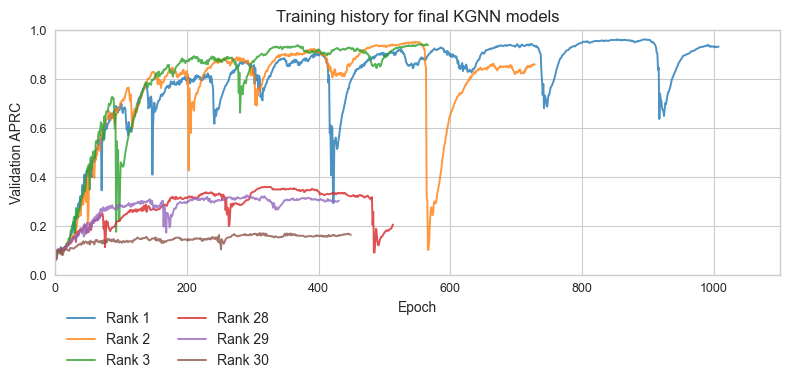

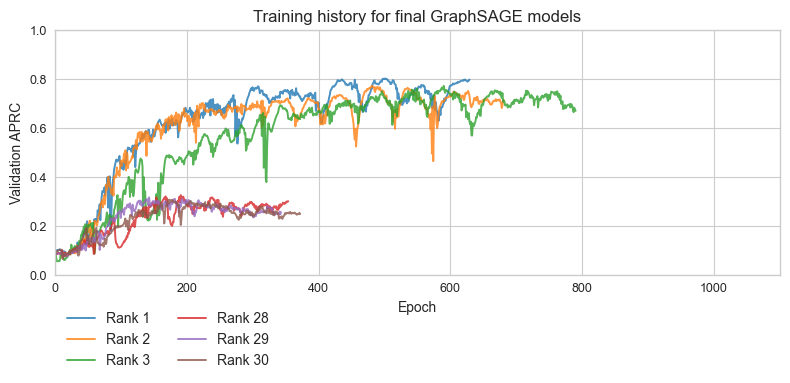

In [59]:

for i, model_name in enumerate(gnn_models):
    fig, ax = plt.subplots(figsize=(8, 4))

    study = optuna.load_study(
        study_name=f"pyg_model_selection_{model_name}_WEIGHTS",
        storage=f"sqlite:///{OPTUNA_DB}",
    )
    
    sorted_trials = (study
        .trials_dataframe()
        .sort_values("value", ascending=False)
        .reset_index(drop=True)
    )
    top = sorted_trials.tail(3)
    bottom = sorted_trials.head(3)
    sample = pd.concat([top, bottom]).sort_values("value", ascending=False)

    ax.set_title(f"Validation APRC for final {model_name} models")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Validation APRC")
    ax.set_xlim(0, 1100)
    ax.set_ylim(0, 1)

    for idx, (i, trial) in enumerate(sample.iterrows()):
        assert isinstance(i, int)
        ax.plot(trial["user_attrs_aprc_history"], label=f"Rank {i + 1}", alpha=0.8)

    
    ax.legend(loc="upper left", bbox_to_anchor=(0, -0.1), ncol=2)
    fig.tight_layout()
    fig.savefig(f"figures/training-history-{model_name}.png", dpi=300)